In [ ]:
#installing the required packages
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import re    
import nltk  
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.downloader.download('vader_lexicon')
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer   

from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Dataset link : https://drive.google.com/file/d/1himTj9_I44QqSPZ7OZKnNR-hPkL_mbS0/view?usp=sharing

In [ ]:
data = pd.read_csv('drive/MyDrive/SNTA/twcs.csv')
data

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [ ]:
#let us take first 10,000 data 

df = data[['text']][0:10000]
df

,text
0,@115712 I understand. I would like to assist y...
1,@sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messag...
3,@115712 Please send us a Private Message so th...
4,@sprintcare I did.
...,...
9995,@MicrosoftHelps That link just gives me gibber...
9996,"@118890 In that case, kindly contact our Answe..."
9997,@MicrosoftHelps Has any other Windows 10 user ...
9998,@118890 1/2 Your Internet Service Provider can...


In [ ]:
# function to coonvert the tweets to words (text)

def twt(tweet):
  
  txt = tweet.lower()
  txt = re.sub(r"[^a-zA-Z0-9]", " ", txt)
  words = txt.split()
  words = [w for w in words if w not in stopwords.words("english")]
  words = [PorterStemmer().stem(w) for w in words]
  return words


In [ ]:
#splitting sentence into words
CT=[]
for item in tqdm(df['text']):
    words=twt(str(item))
    CT+=[words]
df['cleantext']=CT
df

100%|██████████| 10000/10000 [00:25<00:00, 386.89it/s]


,text,cleantext
0,@115712 I understand. I would like to assist y...,"[115712, understand, would, like, assist, woul..."
1,@sprintcare and how do you propose we do that,"[sprintcar, propos]"
2,@sprintcare I have sent several private messag...,"[sprintcar, sent, sever, privat, messag, one, ..."
3,@115712 Please send us a Private Message so th...,"[115712, pleas, send, us, privat, messag, assi..."
4,@sprintcare I did.,[sprintcar]
...,...,...
9995,@MicrosoftHelps That link just gives me gibber...,"[microsofthelp, link, give, gibberish, 2a0, tq..."
9996,"@118890 In that case, kindly contact our Answe...","[118890, case, kindli, contact, answer, desk, ..."
9997,@MicrosoftHelps Has any other Windows 10 user ...,"[microsofthelp, window, 10, user, notic, massi..."
9998,@118890 1/2 Your Internet Service Provider can...,"[118890, 1, 2, internet, servic, provid, check..."


In [ ]:
# words to sentence
def WTS(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [ ]:
WTS(['a','b','c'])

'a b c '

In [ ]:
#computing vader scores sentiment intensity
def VScore(df, label):
    SIA = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: SIA.polarity_scores(WTS(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: SIA.polarity_scores(WTS(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: SIA.polarity_scores(WTS(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: SIA.polarity_scores(WTS(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: WTS(x))
    return df

In [ ]:
df2 = VScore(df,'cleantext')
df2

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,@115712 I understand. I would like to assist y...,"[115712, understand, would, like, assist, woul...",0.000,0.815,0.185,0.3612,115712 understand would like assist would need...
1,@sprintcare and how do you propose we do that,"[sprintcar, propos]",0.000,1.000,0.000,0.0000,sprintcar propos
2,@sprintcare I have sent several private messag...,"[sprintcar, sent, sever, privat, messag, one, ...",0.000,1.000,0.000,0.0000,sprintcar sent sever privat messag one respond...
3,@115712 Please send us a Private Message so th...,"[115712, pleas, send, us, privat, messag, assi...",0.000,0.847,0.153,0.2023,115712 pleas send us privat messag assist clic...
4,@sprintcare I did.,[sprintcar],0.000,1.000,0.000,0.0000,sprintcar
...,...,...,...,...,...,...,...
9995,@MicrosoftHelps That link just gives me gibber...,"[microsofthelp, link, give, gibberish, 2a0, tq...",0.000,0.833,0.167,0.4939,microsofthelp link give gibberish 2a0 tqo0 amp...
9996,"@118890 In that case, kindly contact our Answe...","[118890, case, kindli, contact, answer, desk, ...",0.000,0.710,0.290,0.5423,118890 case kindli contact answer desk support...
9997,@MicrosoftHelps Has any other Windows 10 user ...,"[microsofthelp, window, 10, user, notic, massi...",0.000,1.000,0.000,0.0000,microsofthelp window 10 user notic massiv data...
9998,@118890 1/2 Your Internet Service Provider can...,"[118890, 1, 2, internet, servic, provid, check...",0.000,1.000,0.000,0.0000,118890 1 2 internet servic provid check anoth ...


In [ ]:
# vader_classes = ['Vader_Negative','Vader_Neutral','Vader_Positive']
CL0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_comp']<0.0:
        CL0+=[0]
    elif df2.loc[i,'vader_comp']==0.0:
        CL0+=[1]        
    else:
        CL0+=[2]   
        
df2['class']=CL0
df2['class'].value_counts()



2    4836
1    3636
0    1528
Name: class, dtype: int64

In [ ]:
df2

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,@115712 I understand. I would like to assist y...,"[115712, understand, would, like, assist, woul...",0.000,0.815,0.185,0.3612,115712 understand would like assist would need...,2
1,@sprintcare and how do you propose we do that,"[sprintcar, propos]",0.000,1.000,0.000,0.0000,sprintcar propos,1
2,@sprintcare I have sent several private messag...,"[sprintcar, sent, sever, privat, messag, one, ...",0.000,1.000,0.000,0.0000,sprintcar sent sever privat messag one respond...,1
3,@115712 Please send us a Private Message so th...,"[115712, pleas, send, us, privat, messag, assi...",0.000,0.847,0.153,0.2023,115712 pleas send us privat messag assist clic...,2
4,@sprintcare I did.,[sprintcar],0.000,1.000,0.000,0.0000,sprintcar,1
...,...,...,...,...,...,...,...,...
9995,@MicrosoftHelps That link just gives me gibber...,"[microsofthelp, link, give, gibberish, 2a0, tq...",0.000,0.833,0.167,0.4939,microsofthelp link give gibberish 2a0 tqo0 amp...,2
9996,"@118890 In that case, kindly contact our Answe...","[118890, case, kindli, contact, answer, desk, ...",0.000,0.710,0.290,0.5423,118890 case kindli contact answer desk support...,2
9997,@MicrosoftHelps Has any other Windows 10 user ...,"[microsofthelp, window, 10, user, notic, massi...",0.000,1.000,0.000,0.0000,microsofthelp window 10 user notic massiv data...,1
9998,@118890 1/2 Your Internet Service Provider can...,"[118890, 1, 2, internet, servic, provid, check...",0.000,1.000,0.000,0.0000,118890 1 2 internet servic provid check anoth ...,1


In [ ]:
#tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def Tokenize(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer



In [ ]:
print('Previous text\n')
print(df2['cleantext2'][0])
X, tokenizer = Tokenize(df2['cleantext2'])
print('\n')
print('Present text\n', X[0])
print(X.shape)

Previous text

115712 understand would like assist would need get privat secur link assist 


Present text
 [1549  252   48   17   31   48   26    8  693  499   69   31    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(10000, 50)


In [ ]:
y = pd.get_dummies(df2['class'])  
print(y)

      0  1  2
0     0  0  1
1     0  1  0
2     0  1  0
3     0  0  1
4     0  1  0
...  .. .. ..
9995  0  0  1
9996  0  0  1
9997  0  1  0
9998  0  1  0
9999  1  0  0

[10000 rows x 3 columns]


In [ ]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (6000, 50) (6000, 3)
Validation Set:  (2000, 50) (2000, 3)
Test Set:  (2000, 50) (2000, 3)


In [ ]:
import tensorflow.keras.backend as K

def f1S(precision, recall):    
    f1value = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1value

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
# SGD model
sgd = tf.keras.optimizers.legacy.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


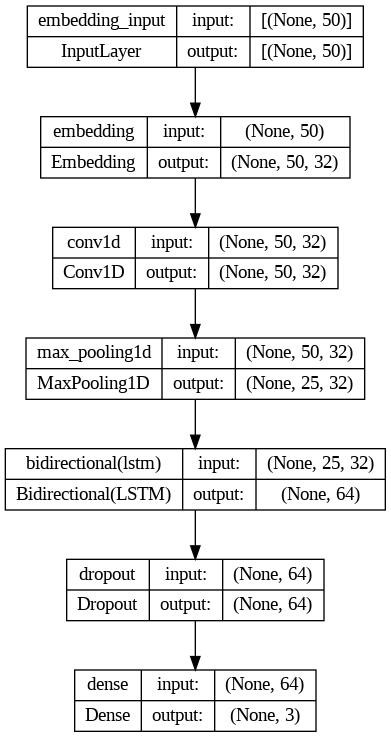

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/50
94/94 [==============================] - 10s 55ms/step - loss: 1.0097 - accuracy: 0.4773 - precision: 0.4944 - recall: 0.1617 - val_loss: 1.0020 - val_accuracy: 0.5055 - val_precision: 0.6667 - val_recall: 0.0070
Epoch 2/50
94/94 [==============================] - 3s 32ms/step - loss: 0.9840 - accuracy: 0.5100 - precision: 0.5409 - recall: 0.2975 - val_loss: 0.9880 - val_accuracy: 0.5030 - val_precision: 0.5151 - val_recall: 0.4355
Epoch 3/50
94/94 [==============================] - 3s 32ms/step - loss: 0.9653 - accuracy: 0.5360 - precision: 0.5763 - recall: 0.3695 - val_loss: 0.9567 - val_accuracy: 0.5550 - val_precision: 0.6051 - val_recall: 0.4060
Epoch 4/50
94/94 [==============================] - 5s 51ms/step - loss: 0.8751 - accuracy: 0.6160 - precision: 0.6803 - recall: 0.4812 - val_loss: 0.7844 - val_accuracy: 0.6525 - val_precision: 0.7380 - val_recall: 0.5605
Epoch 5/50
94/94 [==============================] - 3s 35ms/step - loss: 0.6555 - accuracy: 0.7455 - precis

In [ ]:
#evaluating test results
X_test

array([[ 114,  138,  198, ...,    0,    0,    0],
       [2022,    2,    1, ...,    0,    0,    0],
       [1790,  273,  277, ...,    0,    0,    0],
       ...,
       [ 517,  156,   38, ...,    0,    0,    0],
       [  52, 2162,    6, ...,    0,    0,    0],
       [ 172, 1215,   19, ...,    0,    0,    0]], dtype=int32)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1S(precision, recall)))

Accuracy  : 0.8925
Precision : 0.8934
Recall    : 0.8925
F1 Score  : 0.8929


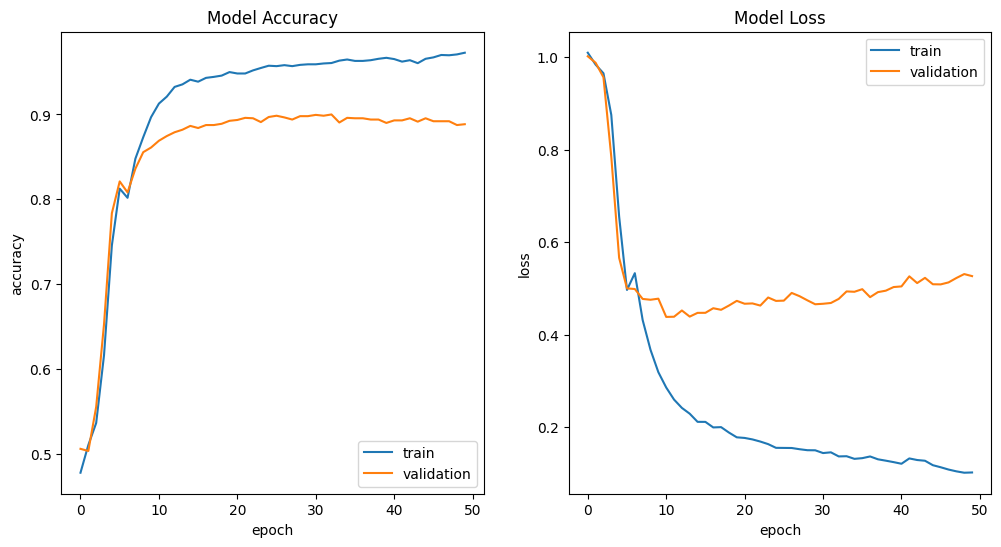

In [ ]:
def plotModel(history):    
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plotModel(history)

63/63 [==============================] - 2s 6ms/step
2    964
1    731
0    305
dtype: int64
2    980
1    711
0    309
dtype: int64


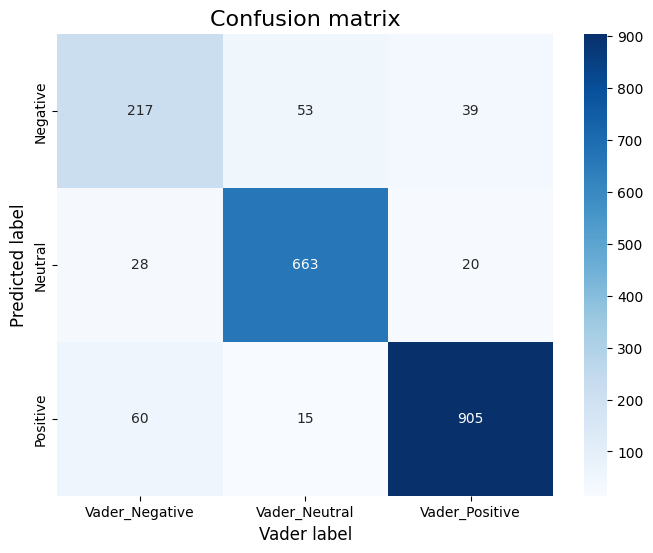

In [ ]:
from sklearn.metrics import confusion_matrix

def plotCM(model, X_test, y_test):
    
    sentiment_classes =   ['Negative','Neutral', 'Positive']
    vader_classes =   ['Vader_Negative','Vader_Neutral', 'Vader_Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=vader_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Vader label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plotCM(model, X_test, y_test)

In [ ]:
vader_classes= ['Vader_Negative','Vader_Neutral', 'Vader_Positive']
y_pred = model.predict(X_test)
Y_PRED=np.argmax(y_pred,axis=1)
print(Y_PRED)

63/63 [==============================] - 0s 6ms/step
[2 2 1 ... 2 2 1]


In [ ]:
print(y_test)
Y_TRUE=np.argmax(np.array(y_test),axis=1)
print(Y_TRUE)

      0  1  2
9953  0  0  1
3850  0  0  1
4962  0  1  0
3886  0  1  0
5437  0  0  1
...  .. .. ..
3919  0  1  0
162   0  0  1
7903  0  0  1
2242  0  0  1
2745  0  1  0

[2000 rows x 3 columns]
[2 2 1 ... 2 2 1]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_TRUE, Y_PRED, target_names=vader_classes, digits=4))

                precision    recall  f1-score   support

Vader_Negative     0.7023    0.7115    0.7068       305
 Vader_Neutral     0.9325    0.9070    0.9196       731
Vader_Positive     0.9235    0.9388    0.9311       964

      accuracy                         0.8925      2000
     macro avg     0.8527    0.8524    0.8525      2000
  weighted avg     0.8930    0.8925    0.8927      2000

